In [1]:
import pandas as pd 
import numpy as np 
from collections import Counter 
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import re

import nltk
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
from nltk.corpus import stopwords

from wordcloud import WordCloud 

from sklearn.utils import resample
from sklearn.decomposition import TruncatedSVD 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import v_measure_score
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import string

from textblob import TextBlob

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cafe6\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
def rm_punct_symb(phrase):
    phrase_no_punct = "".join([i for i in phrase if i not in string.punctuation])
    return phrase_no_punct

# Data preparation

In [3]:
# Importazione dataset e riconversione colonna in lista di stringhe, come già fatto nel preprocessing

df = pd.read_csv('C:/Users/cafe6/Documents/GitHub/Dati TextMining/df_lemmatized.csv')
df['Lemmatized Text'] = df['Lemmatized Text'].apply(rm_punct_symb)
df['Lemmatized Text'] = df['Lemmatized Text'].str.split(' ')

In [4]:
# Mantengo solo le colonne necessarie al clustering

clust_df = df[['Lemmatized Text', 'Score']]

In [5]:
clust_df.head()

,Lemmatized Text,Score
0,"[bought, several, vitality, canned, dog, food,...",5
1,"[product, arrived, labelled, lumbo, halted, pe...",1
2,"[connection, around, century, light, pillow, c...",4
3,"[looking, secret, ingredient, robitussin, beli...",2
4,"[great, staff, great, price, wide, assortment,...",5


Sappiamo che le review sono sbilanciate verso la classe '4' e '5': procedo al downsampling.

Text(0, 0.5, 'Number of reviews')

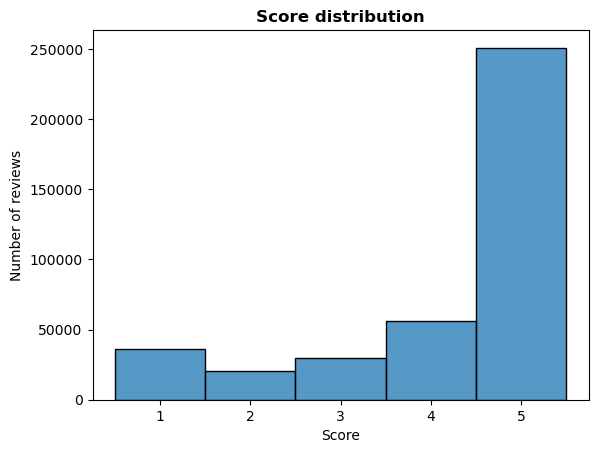

In [6]:
sns.histplot(clust_df['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [9]:
sample_size = clust_df.groupby('Score').count().min()[0] # Prendo come dimensione quella minima fra tutte le classi

df_downsampled = clust_df.groupby('Score', group_keys=False).apply(lambda x: x.sample(sample_size))
df_downsampled

,Lemmatized Text,Score
351921,"[dont, know, well, insecticide, work, could, g...",1
306465,"[delivered, product, around, spaggetti, box, a...",1
75840,"[drinking, costa, ricans, coffee, year, came, ...",1
302607,"[save, money, even, sauce, thought, eating, do...",1
302539,"[son, love, elbas, kitchen, fruit, verge, pouc...",1
...,...,...
146642,"[ordered, cereal, subscribe, save, cheap, pric...",5
377518,"[thrilled, find, avoids, ginger, available, am...",5
322393,"[recently, saw, vital, coronet, water, sale, c...",5
133608,"[tea, amazing, great, new, tea, enjoyed, tea, ...",5


Text(0, 0.5, 'Number of reviews')

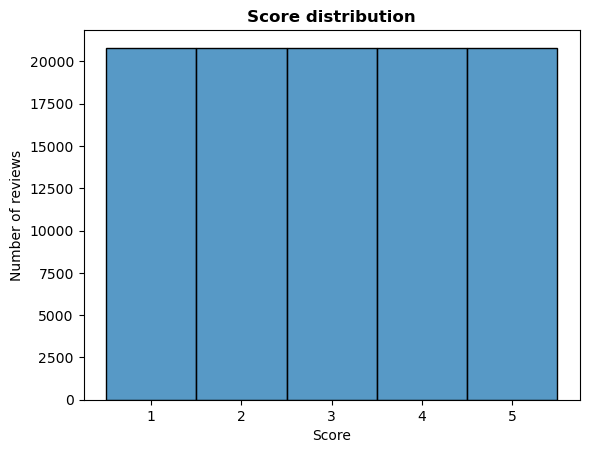

In [10]:
sns.histplot(df_downsampled['Score'], discrete=True)
plt.title("Score distribution", fontweight='bold')
plt.xlabel("Score")
plt.ylabel("Number of reviews")

In [11]:
# Eseguo uno shuffle dei dati

df_4_clustering = shuffle(df_downsampled, random_state = 123)
df_4_clustering.head()

,Lemmatized Text,Score
179027,"[love, anything, chocolateand, almost, every, ...",1
210404,"[appreciate, namastes, line, allergen, leave, ...",2
270887,"[pad, delicious, convenient, expensive, worrie...",5
273389,"[theyve, raised, price, noble, product, paying...",4
117040,"[television, commercial, pepperidge, farm, mil...",2


In [12]:
# Divido x e y

x_clust = df_4_clustering['Lemmatized Text']
y_clust = df_4_clustering['Score']

# Clustering

## BOW

In [23]:
cv = CountVectorizer(min_df=0., max_df=1.0)
cv_model = cv.fit(x_clust.astype(str)) 
x_clust_BOW = cv_model.transform(x_clust.astype(str))

In [24]:
tSVD_BOW = TruncatedSVD(n_components = 1000)
SVD_BOW = tSVD_BOW.fit(x_clust_BOW)
x_clust_BOW = tSVD_BOW.transform(x_clust_BOW)
print(SVD_BOW.explained_variance_ratio_.sum())

0.7975663681341931


In [ ]:
# Normalizzo i dati

# x_clust_BOW_norm = preprocessing.normalize(x_clust_BOW)

### K-means

In [25]:
n_cluster = 5
k_means = KMeans(n_clusters=n_cluster, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_BOW)
y_k_means = k_means.predict(x_clust_BOW)

In [26]:
print(f'''V measure: {v_measure_score(y_k_means, y_clust)}''')
print(f'''Adjusted Rand Index: {adjusted_rand_score(y_k_means, y_clust)}''')

V measure: 0.006521313553687253
Adjusted Rand Index: 0.002580407143986559


## TF-IDF

In [14]:
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_model = tv.fit(x_clust.astype(str))
x_clust_TFIDF = tv.transform(x_clust.astype(str))

In [15]:
tSVD_TFIDF = TruncatedSVD(n_components = 1000)
SVD_TFIDF = tSVD_TFIDF.fit(x_clust_TFIDF)
x_clust_TFIDF = tSVD_TFIDF.transform(x_clust_TFIDF)
print(SVD_TFIDF.explained_variance_ratio_.sum())

0.5641514593482457


In [ ]:
# Normalizzo i dati

# x_clust_TFIDF_norm = preprocessing.normalize(x_clust_TFIDF)

### K-means

In [16]:
n_cluster = 5
k_means = KMeans(n_clusters=n_cluster, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_TFIDF)
y_k_means = k_means.predict(x_clust_TFIDF)

In [18]:
print(f'''V measure: {v_measure_score(y_k_means, y_clust)}''')
print(f'''Adjusted Rand Index: {adjusted_rand_score(y_k_means, y_clust)}''')

V measure: 0.0014930992852929602
Adjusted Rand Index: 0.0002900744815036901


## W2V

In [27]:
w2v_model = gensim.models.Word2Vec(x_clust, vector_size=300, window=8, min_count=2)
words = set(w2v_model.wv.index_to_key)

In [28]:
x_clust_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_clust])

In [29]:
x_clust_avg = []
for v in x_clust_vect:
    if v.size:
        x_clust_avg.append(v.mean(axis=0))
    else:
        x_clust_avg.append(np.zeros(300, dtype=float))

In [ ]:
# Normalizzo i dati

# x_clust_avg_norm = preprocessing.normalize(x_clust_avg)

### K-means

In [30]:
n_cluster = 5
k_means = KMeans(n_clusters=n_cluster, max_iter=20, n_init=10, random_state=123)
k_means = k_means.fit(x_clust_avg)
y_k_means = k_means.predict(x_clust_avg)

In [31]:
print(f'''V measure: {v_measure_score(y_k_means, y_clust)}''')
print(f'''Adjusted Rand Index: {adjusted_rand_score(y_k_means, y_clust)}''')

V measure: 0.010985978410116075
Adjusted Rand Index: 0.009217988442792549


# Idee successive

- Altri metodi di clustering (DBSCAN, Agglomerative clustering, ...)
- Ottimizzazione iperparametri
    - Sia quelli di BOW/TF-IDF/W2V che quelli degli algoritmi di clustering (n_init, max_iter)
    - Lavorare sul numero di cluster ottimale: per provare il modello ho lavorato ipotizzando che siano 5 cluster, ma in realtà la suddivisione in cluster va in base all'argomento della review, che non centra nulla con il voto associato alla review stessa. Probabilmente avrebbe più senso iterare per cercare il numero ottimale di cluster e valutare diverse misure di performance
- Misure di performance: per ora ho considerato v_measure e ARI ipotizzando che la classe a cui appartengono le review sia la ground truth (cosa scorretta). Questo discorso si riallaccia a quello precedente sul numero di clusters 